# Testing Different ML Models on Flex Sensor Bend Data #

## Imports ##

In [14]:
!pip install xgboost

In [15]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Model training & pipelines
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Models
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel, ConstantKernel as C
# from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Data Collection ##

In this notebook, the data I have here is from Wally's work, Besufekad's, and some simulated data I made.

In [16]:
# Load the datasets
file1 = "flex_sensor_data.csv"

df1 = pd.read_csv(file1)

# Concatenate the DataFrames
df = pd.concat([df1], ignore_index=True)  # `ignore_index=True` resets the index

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle and reset index

# Display first few rows
print(df.head())

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Check data types
print("Data types:\n", df.dtypes)

df.describe

   Angle (degrees)  Resistance (kÎ©)
0              165             22.07
1              116             17.14
2              117             17.21
3              180             20.36
4              180             20.00
Missing values:
 Angle (degrees)     0
Resistance (kÎ©)    0
dtype: int64
Data types:
 Angle (degrees)       int64
Resistance (kÎ©)    float64
dtype: object


<bound method NDFrame.describe of      Angle (degrees)  Resistance (kÎ©)
0                165             22.07
1                116             17.14
2                117             17.21
3                180             20.36
4                180             20.00
..               ...               ...
812               71             13.09
813              106             19.57
814               91             14.77
815               73             12.48
816              102             19.83

[817 rows x 2 columns]>

## Data Prep ##

We will be testing to see if the model can accurately predict the bending angle of the sensor based on resistance readings.

In [17]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Angle (degrees)'])  # Replace 'TargetColumn' with the actual column name
y = df['Angle (degrees)']

# Split data into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional, based on sensor value range)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Training the Models ##

The models that will be tested in this notebook:
* Baseline models:
    * Random Forest
    * Linear Regression
    * Polynomial Regression
* Advance models:
    * XGBoost Regression
    * Gaussian Process Regression
    * Model Generalization (combining all models together)

## Evaluation ##

Metrics to be used:
* Mean squared error (MSE) - measures error magnitude
* R**2 - evaluates model accuracy
* Prediction curve evaluation - plots actual vs. predicted bending angles to observe trends

### Random Forest Model ###

In [18]:
# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],  # Number of trees
    'max_depth': [10, 20, 30, None],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples in a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features per split
    'bootstrap': [True, False]  # Bootstrapping
}

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Define parameter space for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500, 700],  # More options for better tuning
    'max_depth': [10, 20, 30, 50, 60, None],  # None allows fully grown trees
    'min_samples_split': [2 ,3, 4, 5, 6],  # More splits to avoid overfitting
    'min_samples_leaf': [1, 2, 4 , 5, 6],  # Controls complexity
    'max_features': ['sqrt', 'log2', None],  # Feature selection strategies
    'bootstrap': [True, False]  # Bootstrapping options
}

# Randomized Search with Cross Validation (5-fold)
random_search = RandomizedSearchCV(
    estimator=rf_model, param_distributions=param_dist,
    n_iter=20,  # Randomly test 20 different combinations
    scoring='r2', cv=5, n_jobs=-1, verbose=2, random_state=42
)

# Fit Randomized Search to training data
random_search.fit(X_train, y_train)

# Best parameters
print("\nBest Hyperparameters:", random_search.best_params_)

# Train Random Forest with best parameters
best_rf_model = random_search.best_estimator_

# Make predictions
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
n, p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("\n🌲 Random Forest Performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adjusted_r2:.4f}")

# Cross-Validation
cv_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='r2')
cv_preds = cross_val_predict(best_rf_model, X, y, cv=5)
cv_rmse = np.sqrt(mean_squared_error(y, cv_preds))
cv_mae = mean_absolute_error(y, cv_preds)
cv_r2 = r2_score(y, cv_preds)

print(f"\n🔁 Cross-Validation (5-Fold):")
print(f"R² Scores: {cv_scores}")
print(f"Average R²: {cv_scores.mean():.4f}")
print(f"CV RMSE: {cv_rmse:.4f}")
print(f"CV MAE: {cv_mae:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}

🌲 Random Forest Performance:
MAE: 10.4630
MSE: 195.7877
RMSE: 13.9924
R²: 0.9255
Adjusted R²: 0.9250

🔁 Cross-Validation (5-Fold):
R² Scores: [0.93908499 0.92747528 0.94255427 0.93998812 0.94664428]
Average R²: 0.9391
CV RMSE: 12.8123
CV MAE: 9.4690


### XGBoost Training Model ###

In [19]:
# Initialize XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define hyperparameter grid for tuning
param_dist = {
    'n_estimators': [100, 300, 500, 700],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # How much each tree contributes
    'max_depth': [3, 5, 7, 10],  # Complexity control
    'min_child_weight': [1, 3, 5],  # Minimum weight needed for a new node split
    'gamma': [0, 0.1, 0.3, 0.5],  # Regularization parameter
    'colsample_bytree': [0.5, 0.7, 1],  # Percentage of features used per tree
    'subsample': [0.6, 0.8, 1]  # Fraction of samples per tree
}

# Randomized Search with Cross Validation (5-fold)
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model, param_distributions=param_dist,
    n_iter=20,  # Randomly test 20 different combinations
    scoring='r2', cv=5, n_jobs=-1, verbose=2, random_state=42
)

# Fit Randomized Search to training data
random_search_xgb.fit(X_train, y_train)

# Best parameters
print("\nBest Hyperparameters:", random_search_xgb.best_params_)

# Train XGBoost with best parameters
best_xgb_model = random_search_xgb.best_estimator_

# Make predictions
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)
n, p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("\n🌲 XGBoost Performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adjusted_r2:.4f}")

# Cross-Validation
cv_scores = cross_val_score(best_xgb_model, X, y, cv=5, scoring='r2')
cv_preds = cross_val_predict(best_xgb_model, X, y, cv=5)
cv_rmse = np.sqrt(mean_squared_error(y, cv_preds))
cv_mae = mean_absolute_error(y, cv_preds)
cv_r2 = r2_score(y, cv_preds)

print(f"\n🔁 Cross-Validation (5-Fold):")
print(f"R² Scores: {cv_scores}")
print(f"Average R²: {cv_scores.mean():.4f}")
print(f"CV RMSE: {cv_rmse:.4f}")
print(f"CV MAE: {cv_mae:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1}

🌲 XGBoost Performance:
MAE: 10.1004
MSE: 185.8436
RMSE: 13.6324
R²: 0.9293
Adjusted R²: 0.9288

🔁 Cross-Validation (5-Fold):
R² Scores: [0.94152391 0.92800128 0.94406664 0.94301599 0.94686347]
Average R²: 0.9407
CV RMSE: 12.6548
CV MAE: 9.3422


### Linear Regression Model ###

In [20]:
# Train
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)
n, p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("\n📉 Linear Regression Performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adjusted_r2:.4f}")

# Coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr_model.coef_})
print("\nModel Coefficients:")
print(coef_df)
print(f"Intercept: {lr_model.intercept_:.4f}")

# Cross-Validation
cv_scores = cross_val_score(lr_model, X, y, cv=5, scoring='r2')
cv_preds = cross_val_predict(lr_model, X, y, cv=5)
cv_rmse = np.sqrt(mean_squared_error(y, cv_preds))
cv_mae = mean_absolute_error(y, cv_preds)
cv_r2 = r2_score(y, cv_preds)

print(f"\n🔁 Cross-Validation (5-Fold):")
print(f"R² Scores: {cv_scores}")
print(f"Average R²: {cv_scores.mean():.4f}")
print(f"CV RMSE: {cv_rmse:.4f}")
print(f"CV MAE: {cv_mae:.4f}")


📉 Linear Regression Performance:
MAE: 9.4922
MSE: 175.6897
RMSE: 13.2548
R²: 0.9331
Adjusted R²: 0.9327

Model Coefficients:
            Feature  Coefficient
0  Resistance (kÎ©)    50.402003
Intercept: 85.1501

🔁 Cross-Validation (5-Fold):
R² Scores: [0.93779709 0.91996419 0.93854673 0.93746932 0.94248632]
Average R²: 0.9353
CV RMSE: 13.2260
CV MAE: 9.7152


### Polynomial Regression Model ###

In [21]:
# Initialize and train model
degree = 4
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(X_train, y_train)

# Predict on test data
y_pred_poly = poly_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred_poly)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_poly)
r2 = r2_score(y_test, y_pred_poly)
n, p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Output results
print("\n🔢 Polynomial Regression (Degree 4) Performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adjusted_r2:.4f}")

# Cross-Validation
cv_scores = cross_val_score(poly_model, X, y, cv=5, scoring='r2')
cv_preds = cross_val_predict(poly_model, X, y, cv=5)
cv_rmse = np.sqrt(mean_squared_error(y, cv_preds))
cv_mae = mean_absolute_error(y, cv_preds)
cv_r2 = r2_score(y, cv_preds)

print(f"\n🔁 Cross-Validation (5-Fold):")
print(f"R² Scores: {cv_scores}")
print(f"Average R²: {cv_scores.mean():.4f}")
print(f"CV RMSE: {cv_rmse:.4f}")
print(f"CV MAE: {cv_mae:.4f}")


🔢 Polynomial Regression (Degree 4) Performance:
MAE: 9.4808
MSE: 169.4420
RMSE: 13.0170
R²: 0.9355
Adjusted R²: 0.9351

🔁 Cross-Validation (5-Fold):
R² Scores: [0.94681453 0.92703054 0.94499654 0.94690435 0.94734703]
Average R²: 0.9426
CV RMSE: 12.4605
CV MAE: 9.0127


### Gaussian Process Regression Model ###

In [22]:
# Try RationalQuadratic (can model multiple scales of variation)
kernel = C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=1.0, alpha=1.0) + WhiteKernel()

# Initialize the Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True, random_state=42)

# Fit the model
gpr.fit(X_train, y_train)

# Predict mean and standard deviation
y_pred_gpr, y_std_gpr = gpr.predict(X_test, return_std=True)

# Evaluate
mse = mean_squared_error(y_test, y_pred_gpr)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_gpr)
r2 = r2_score(y_test, y_pred_gpr)
n, p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("\n📈 Gaussian Process Regression Performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adjusted_r2:.4f}")

# # Cross-Validation
# cv_scores = cross_val_score(gpr, X, y, cv=5, scoring='r2')
# cv_preds = cross_val_predict(gpr, X, y, cv=5)
# cv_rmse = np.sqrt(mean_squared_error(y, cv_preds))
# cv_mae = mean_absolute_error(y, cv_preds)
# cv_r2 = r2_score(y, cv_preds)

# print(f"\n🔁 Cross-Validation (5-Fold):")
# print(f"R² Scores: {cv_scores}")
# print(f"Average R²: {cv_scores.mean():.4f}")
# print(f"CV RMSE: {cv_rmse:.4f}")
# print(f"CV MAE: {cv_mae:.4f}")

C:\Users\bharg\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)



📈 Gaussian Process Regression Performance:
MAE: 9.3938
MSE: 167.5291
RMSE: 12.9433
R²: 0.9362
Adjusted R²: 0.9358


### Plot Comparison ###

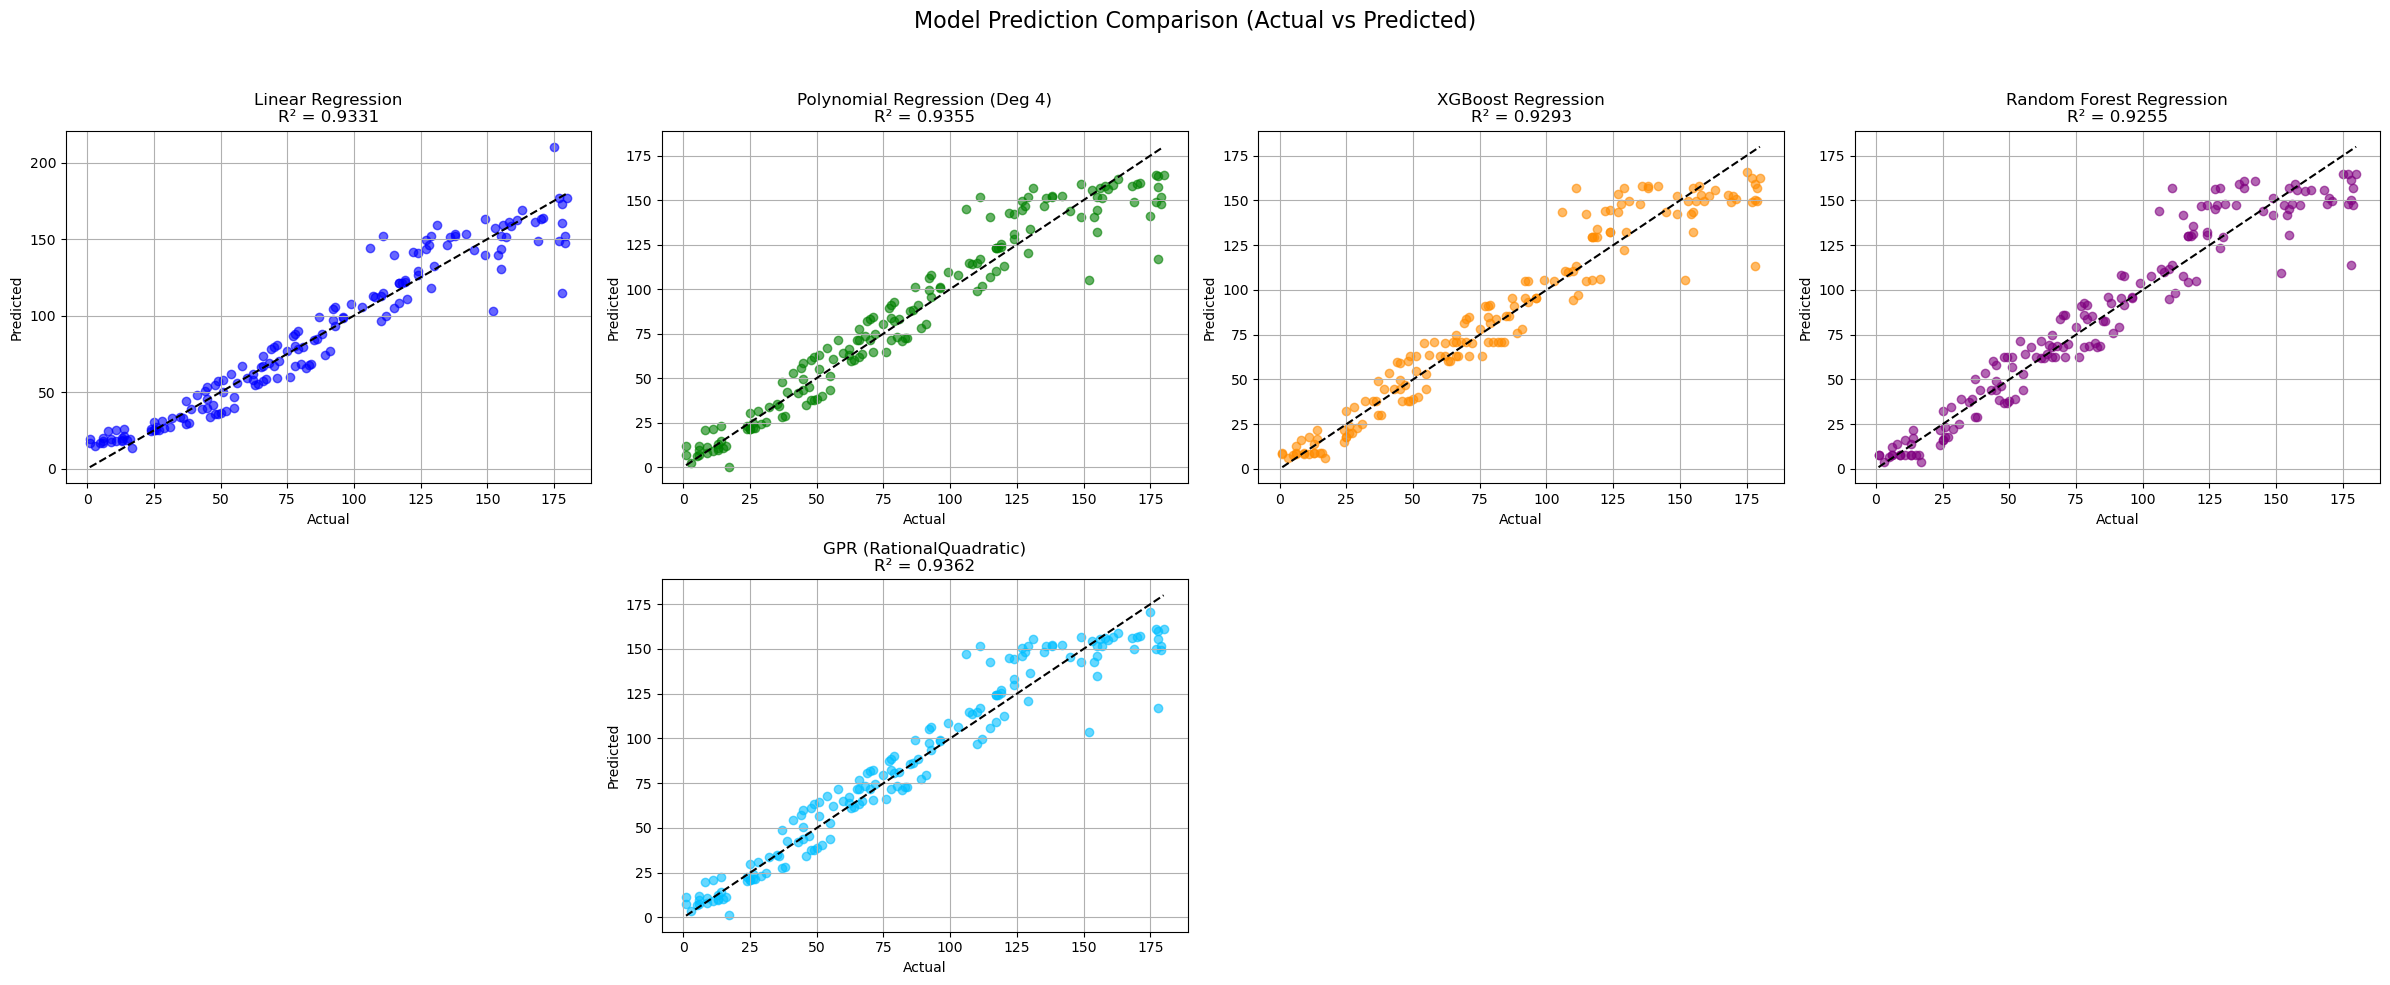

In [23]:
plt.figure(figsize=(24, 10))

# 1. Linear Regression
plt.subplot(2, 4, 1)
plt.scatter(y_test, y_pred_lr, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title(f'Linear Regression\nR² = {r2_score(y_test, y_pred_lr):.4f}')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

# 2. Polynomial Regression (Deg 4)
plt.subplot(2, 4, 2)
plt.scatter(y_test, y_pred_poly, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title(f'Polynomial Regression (Deg 4)\nR² = {r2_score(y_test, y_pred_poly):.4f}')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

# 3. XGBoost
plt.subplot(2, 4, 3)
plt.scatter(y_test, y_pred_xgb, color='darkorange', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title(f'XGBoost Regression\nR² = {r2_score(y_test, y_pred_xgb):.4f}')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

# 4. Random Forest
plt.subplot(2, 4, 4)
plt.scatter(y_test, y_pred_rf, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title(f'Random Forest Regression\nR² = {r2_score(y_test, y_pred_rf):.4f}')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

# 6. Gaussian Process Regression
plt.subplot(2, 4, 6)
plt.scatter(y_test, y_pred_gpr, color='deepskyblue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title(f'GPR (RationalQuadratic)\nR² = {r2_score(y_test, y_pred_gpr):.4f}')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

# # 7. Empty slot (optional use later)
# plt.subplot(2, 4, 7)
# plt.axis('off')

plt.suptitle('Model Prediction Comparison (Actual vs Predicted)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [24]:
from xgboost import XGBRegressor
from sklearn.utils import resample
import numpy as np

# Configuration
n_models = 10  # number of XGBoost models
xgb_models = []
xgb_preds = []

# Train models on bootstrapped data
for i in range(n_models):
    # Bootstrap resample the training data
    X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=42 + i)
    
    # Create and train model
    model = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=42 + i,
        verbosity=0
    )
    model.fit(X_boot, y_boot)
    xgb_models.append(model)
    
    # Predict on test set
    pred = model.predict(X_test)
    xgb_preds.append(pred)

# Stack predictions: shape (n_models, n_samples)
xgb_preds = np.array(xgb_preds)

# Compute mean and std (uncertainty)
xgb_pred_mean = np.mean(xgb_preds, axis=0)
xgb_pred_std = np.std(xgb_preds, axis=0)

# Now xgb_pred_mean is your final XGBoost prediction
# xgb_pred_std is your uncertainty estimate


In [26]:
import numpy as np
import pandas as pd

# Predict on test set with all models
lin_pred = lr_model.predict(X_test)
poly_pred = poly_model.predict(X_test)
rf_all_preds = np.array([tree.predict(X_test) for tree in best_rf_model.estimators_])
rf_pred = np.mean(rf_all_preds, axis=0)
xgb_pred = xgb_pred_mean
gpr_pred, gpr_std = gpr.predict(X_test, return_std=True)

# Estimate uncertainty
lin_uncertainty = np.full_like(lin_pred, np.std(y_train - lr_model.predict(X_train)))
poly_uncertainty = np.full_like(poly_pred, np.std(y_train - poly_model.predict(X_train)))
rf_uncertainty = np.std(rf_all_preds, axis=0)
xgb_uncertainty = xgb_pred_std
gpr_uncertainty = gpr_std

# Combine into DataFrame
meta_df = pd.DataFrame({
    'Resistance': X_test.flatten(),
    'Lin_Pred': lin_pred,
    'Lin_Uncertainty': lin_uncertainty,
    'Poly_Pred': poly_pred,
    'Poly_Uncertainty': poly_uncertainty,
    'RF_Pred': rf_pred,
    'RF_Uncertainty': rf_uncertainty,
    'XGB_Pred': xgb_pred,
    'XGB_Uncertainty': xgb_uncertainty,
    'GPR_Pred': gpr_pred,
    'GPR_Uncertainty': gpr_uncertainty,
    'True_Angle': y_test.values
})

# Save to CSV
meta_df.to_csv("meta_model_input.csv", index=False)
